In [1]:
%reload_ext autoreload
%autoreload 2
%reload_ext rpy2.ipython

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.io as sio
import scipy.sparse as sps
from scipy.sparse.linalg import svds
from scipy.linalg import svdvals

from ampute import ampute_mcar, ampute_mar
from coclust_mod_impute import (CoclustModImpute,
                                summarize_blocks, get_block_counts,
                                _impute_block_representative)
from utils import show_matrix
import joblib
import os # to play sound at the end of the execution

In [3]:
np.set_printoptions(precision=3)

In [4]:
%%R
# library(mice)
library(missMDA)
library(FactoMineR)

In [5]:
repartition = pd.read_csv('data/repartition.csv')
repartition.describe()
repartition.head()

,HF00,HF05,HF10,HF15,HF20,HF25,HF30,HF35,HF40,HF45,HF50,HF55,HF60,HF65,HF70,HF75,HF80,Total
count,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000,22.000000
mean,0.275909,0.286364,0.296818,0.305455,0.290455,0.328636,0.333182,0.335455,0.328182,0.328182,0.292273,0.211364,0.212273,0.211818,0.189545,0.155909,0.164091,4.544091
std,0.260707,0.255539,0.248814,0.251580,0.263718,0.319826,0.316113,0.302289,0.277465,0.276692,0.256755,0.181929,0.153714,0.143149,0.124651,0.101309,0.115538,3.822070
min,0.020000,0.030000,0.030000,0.030000,0.020000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000,0.440000
25%,0.150000,0.152500,0.170000,0.172500,0.152500,0.172500,0.175000,0.175000,0.185000,0.177500,0.155000,0.115000,0.122500,0.122500,0.110000,0.090000,0.090000,2.510000
50%,0.215000,0.225000,0.240000,0.240000,0.220000,0.245000,0.250000,0.260000,0.250000,0.260000,0.220000,0.160000,0.170000,0.175000,0.155000,0.120000,0.125000,3.545000
75%,0.282500,0.295000,0.315000,0.332500,0.315000,0.337500,0.340000,0.360000,0.357500,0.365000,0.325000,0.235000,0.257500,0.260000,0.240000,0.190000,0.197500,4.970000
max,1.270000,1.240000,1.200000,1.210000,1.290000,1.590000,1.560000,1.490000,1.370000,1.370000,1.260000,0.880000,0.740000,0.670000,0.570000,0.460000,0.540000,18.710000


,Regions,HF00,HF05,HF10,HF15,HF20,HF25,HF30,HF35,HF40,HF45,HF50,HF55,HF60,HF65,HF70,HF75,HF80,Total
0,ILEF,1.27,1.24,1.20,1.21,1.29,1.59,1.56,1.49,1.37,1.37,1.26,0.88,0.74,0.67,0.57,0.46,0.54,18.71
1,CHAM,0.14,0.15,0.16,0.16,0.15,0.17,0.16,0.17,0.17,0.17,0.15,0.10,0.11,0.10,0.09,0.08,0.08,2.29
2,PICA,0.21,0.22,0.24,0.23,0.20,0.23,0.23,0.24,0.23,0.24,0.20,0.13,0.14,0.14,0.12,0.10,0.09,3.17
3,HNOR,0.19,0.21,0.22,0.22,0.19,0.22,0.22,0.22,0.23,0.22,0.19,0.13,0.13,0.13,0.11,0.09,0.10,3.04
4,CENT,0.24,0.26,0.27,0.27,0.24,0.29,0.29,0.30,0.30,0.31,0.27,0.19,0.21,0.21,0.19,0.16,0.18,4.17


In [6]:
X = np.array([
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0],
    [1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0],
    [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0]])
X = X[np.ix_([0, 2, 7, 1, 4, 8, 3, 5, 6],
             [ 0,  4,  5, 15,  8,  9, 12, 13,  7, 10,  1,  2,  3,  6, 11, 14])]

n_clusters = 3
w = np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 2, 2, 2, 2, 2, 2])
z = np.array([0, 0, 0, 1, 1, 1, 2, 2, 2])

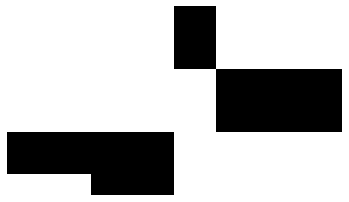

In [7]:
show_matrix(X)

In [8]:
res, r_nan, c_nan = ampute_mcar(X, .1)
print(np.isnan(res).sum())
print(res)

14
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan  0.  1.  1.  1.  1.  1.  1.]
 [ 0. nan nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


In [9]:
def shrink_ca(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
    u, s, v = np.linalg.svd(S, full_matrices=True)

    sigma2 = (s[ncp:]**2).sum() / ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    lambda_shrunk = (s[:ncp]**2 - n * p / min(p,n-1) * sigma2) / s[:ncp]
    
    if ncp == 1:
        recon = (u[:,0] * lambda_shrunk)[:,np.newaxis] @ v[0,:][np.newaxis,:]
    else:
        recon = (u[:,:ncp] * lambda_shrunk) @ v[:ncp,]
    
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    return recon

rec = shrink_ca(X, ncp=3)
np.allclose(X, rec)
np.sum((X - rec)**2)

True

4.934560527463752e-30

In [30]:
np.isclose(0, [0, 0, 1E-16])

array([ True,  True,  True])

In [11]:
# def block_ca(X, Z, W, ncp=2):
#     n, p = X.shape
#     zsum = Z.sum(axis=1)[:, np.newaxis]
#     zsum[zsum == 0] = 1
#     wsum = W.sum(axis=1)[:, np.newaxis]
#     wsum[wsum == 0] = 1
# #     print('wsum', wsum.ravel())
# #     print('zsum', zsum.ravel())
#     Z = Z / zsum
#     W = W / wsum
#     row_cooc = (Z @ Z.T)
#     col_cooc = (W @ W.T)
    
#     row_cooc = row_cooc / row_cooc.sum(axis=1)[:, np.newaxis]
#     col_cooc = col_cooc / col_cooc.sum(axis=0)
    
# #     print('X before cooc\n', X.T, sep='')
#     X = row_cooc @ X @ col_cooc
# #     print('X after cooc\n', X.T, sep='')
#     N = X.sum()
#     P = X / N
#     Rc = P.sum(axis=0)[np.newaxis, :]
#     Rr = P.sum(axis=1)[:, np.newaxis]
    
# #     print('Rr', Rr.ravel())
# #     print('Rc', Rc.ravel())
# #     print('')
#     S = (P - Rr @ Rc) / Rr**.5 / Rc**.5
# #     print(S.T)
#     u, s, v = np.linalg.svd(S, full_matrices=True)

#     sigma2 = (s[ncp:]**2).sum() / ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
#     lambda_shrunk = (s[:ncp]**2 - n * p / min(p,n-1) * sigma2) / s[:ncp]
    
#     if ncp == 1:
#         recon = (row_cooc @ (u[:,0] * lambda_shrunk))[:,np.newaxis] @ ((col_cooc @ v[0,:])[np.newaxis,:])
#     else:
#         recon = (row_cooc @ u[:,:ncp] * lambda_shrunk) @ v[:ncp,] @ col_cooc
    
#     recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
#     return recon

# rec = block_ca(X, z == z[:,np.newaxis], w == w[:,np.newaxis], ncp=5)
# np.allclose(X, rec)
# np.sum((X - rec)**2)

In [13]:
# reconstruction simple
print('reconstruction simple')
rec = shrink_ca(X, ncp=3)
np.allclose(X, rec)
np.sum((X - rec)**2)

# # reconstruction par bloc
# print('reconstruction par bloc')
# rec = block_ca(X, z == z[:,np.newaxis], w == w[:,np.newaxis], ncp=3)
# np.allclose(X, rec)
# np.sum((X - rec)**2)

reconstruction simple


True

4.934560527463752e-30

In [14]:
# def impute_block_ca(X, Z, W, z, w, r_nan, c_nan):
#     rec = block_ca(X, Z, W, ncp=2)
#     X[r_nan, c_nan] = rec[r_nan, c_nan]
#     return X

X_missing, r_nan, c_nan = ampute_mcar(X, .1, random_state=None)
n_clusters = 3
# print(X_missing)
model = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
         .fit(X_missing, _impute_block_representative, initial_vals=None))
impute1 = model.X_

# model2 = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
#           .fit(X_missing, impute_block_ca, initial_vals=None))
# impute2 = model2.X_

print(np.round(impute1.T,2))
# print(np.round(impute2.T,2))

[[0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.86]
 [0.   0.   0.   0.   0.   0.   1.   1.   0.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.86 1.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   1.  ]
 [0.   0.   0.   0.   0.   0.   1.   0.86 1.  ]
 [0.   0.   0.   0.   0.   0.   1.   1.   1.  ]
 [1.   1.   1.   0.   0.   0.   0.   0.   0.  ]
 [1.   1.   1.   0.   0.   0.   0.   0.   0.  ]
 [0.   0.   0.   1.   1.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   1.   0.47 0.   0.   0.  ]
 [0.   0.   0.   1.   1.   1.   0.   0.   0.  ]
 [0.   0.   0.   1.   1.   0.47 0.   0.   0.  ]
 [0.   0.   0.   1.   0.47 0.47 0.   0.   0.  ]
 [0.   0.   0.47 1.   1.   1.   0.   0.   0.  ]]


In [88]:
def shrink_ca2(X, ncp=2):
    n, p = X.shape
    N = X.sum()
    N = 1 if N == 0 else N
    P = X / N
    Rc = P.sum(axis=0)[np.newaxis, :]
    Rr = P.sum(axis=1)[:, np.newaxis]
    Rc[Rc==0] = 1
    Rr[Rr==0] = 1
    S = (P - Rr @ Rc) / Rr**.5 / Rc**.5

    svals = svdvals(S)
    u, s, v = sps.linalg.svds(S, k=ncp)
#     print(s)
#     print(svals)
    zero_vals = np.isclose(0, s) # find which singular values are null
    den = ((n-1)*(p-1) - (n-1)*ncp - (p-1)*ncp + ncp**2)
    sigma2 = (svals[ncp:]**2).sum() / (1 if den == 0 else den)
#     print('sigma2', sigma2)
    lambda_shrunk = s.copy()
#     print(s[~zero_vals])
#     print(lambda_shrunk)
    lambda_shrunk[~zero_vals] = (s[~zero_vals]**2 - n * p / min(p,n-1) * sigma2) / s[~zero_vals]
#     print(lambda_shrunk)
    

    if ncp == 1:
        recon = (u * lambda_shrunk)[:,np.newaxis] @ v[np.newaxis,:]
    else:
        recon = (u * lambda_shrunk) @ v
    
    recon = N * (((recon * Rr**.5) * Rc**.5) + Rr @ Rc)
    return recon

# shrink_ca2(np.array([[0, 0, 0, 0, 0, 0, 0, 0],
#                      [0, 0, 0, 0, 0, 0, 0, 0],
#                      [0, 0, 0, 0, 0, 0, 0, 0]]))
rec = shrink_ca2(X, ncp=5)
np.allclose(X, rec)
np.sum((X - rec)**2)

True

6.232670411901668e-30

In [99]:
def impute_block_ca2(X, Z, W, z, w, r_nan, c_nan, ncp=2):
    z = z.ravel()
    w = w.ravel()
    zvals = np.unique(z)
    wvals = np.unique(w)
    n,p = X.shape
    rows = np.zeros(n, dtype=bool)
    cols = np.zeros(p, dtype=bool)
#     rows[r_nan] = True
#     cols[c_nan] = True
    for zval in zvals:
        for wval in wvals:
            block_z = z==zval
            block_w = w==wval
            z_idx, = np.where(block_z)
            w_idx, = np.where(block_w)
            
            
            
            rows[rows] = False
            cols[cols] = False
            rows[r_nan[z[r_nan] == zval]] = True
            cols[c_nan[w[c_nan] == wval]] = True
            
#             print(rows)
#             print(cols)
            
            if True or np.any(block_z & rows) and np.any(block_w & cols):
                block = X[np.ix_(block_z,block_w)]
                min_dim = min(block.shape)
                print(block)
                if min_dim < 2:
                    summary = block.sum() / block.size
                    X[np.ix_(block_z & rows, block_w & cols)] = summary
                else:
                    recon = shrink_ca2(block, min(ncp, min_dim-1))
#                     print(np.where(rows[block_z])[0])
#                     print(np.where(cols[block_w])[0])
        
#                     print(np.where(rows[block_z & rows])[0])
#                     print(np.where(cols[block_w & cols])[0])
#                     print(recon)
#                     print(np.sum(block_z & rows), np.sum(block_w & cols))
                    X[block_z & rows,block_w & cols] = 0 #recon[np.where(rows[z_idx])[0], np.where(cols[w_idx])[0]]
    print('')
    return X

X_missing, r_nan, c_nan = ampute_mcar(X, .1)
print(r_nan)
print(c_nan)
print(X_missing[r_nan, c_nan])
print(X_missing)
print(X)
impute_block_ca2(X, None, None, z, w, r_nan, c_nan)
# model2 = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
#           .fit(X_missing, impute_block_ca2, initial_vals=None))
# impute2 = model2.X_

[7 1 5 6 3 0 8 4 4 1 3 4 5 8]
[ 5  3  2  1  8 12  4  1  2  2  3 14 14  5]
[nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan  0.  1.  1.  1.  1.  1.  1.]
 [ 0. nan nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]
[[0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1]
 [1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0]
 [1 1 1 1 1 1 1 1 0

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (5,) 

In [108]:
def impute_block_ca2(X, Z, W, z, w, r_nan, c_nan, ncp=2):
    z = z.ravel()
    w = w.ravel()
    zvals = np.unique(z)
    wvals = np.unique(w)
    n,p = X.shape
    rows = np.zeros(n, dtype=bool)
    cols = np.zeros(p, dtype=bool)
#     rows[r_nan] = True
#     cols[c_nan] = True
    nan_mat = sps.csr_matrix((np.ones(r_nan.shape),(r_nan, c_nan)))
    for zval in zvals:
        for wval in wvals:
            block_z = z==zval
            block_w = w==wval
            z_idx, = np.where(block_z)
            w_idx, = np.where(block_w)
               
            rows[rows] = False
            cols[cols] = False
            rows[r_nan[z[r_nan] == zval]] = True
            cols[c_nan[w[c_nan] == wval]] = True
            
            print(f'lignes avec nan block {zval,wval}', block_z @ nan_mat @ block_w[])
            print(block_z)
            if True or np.any(block_z & rows) and np.any(block_w & cols):
                block = X[np.ix_(block_z,block_w)]
                min_dim = min(block.shape)
                print(block)
                if min_dim < 2:
                    summary = block.sum() / block.size
#                     X[np.ix_(block_z & rows, block_w & cols)] = summary
                else:
                    recon = shrink_ca2(block, min(ncp, min_dim-1))
                    
                    X[block_z & rows,block_w & cols] = 0 #recon[np.where(rows[z_idx])[0], np.where(cols[w_idx])[0]]
    print('')
    return X

X_missing, r_nan, c_nan = ampute_mcar(X, .1)

# sps.csr_matrix((np.ones(r_nan.shape),(r_nan, c_nan)))

# print(r_nan)
# print(c_nan)
# print(X_missing[r_nan, c_nan])
print(X_missing)
# print(X)
impute_block_ca2(X, None, None, z, w, r_nan, c_nan)
# # model2 = (CoclustModImpute(n_clusters=n_clusters, n_init=10)
# #           .fit(X_missing, impute_block_ca2, initial_vals=None, ))
# # impute2 = model2.X_

[[ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0. nan  0.  0.  0.]
 [ 0.  0. nan nan  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0. nan  0.  0.  0.  0. nan  0.  1.  1.  1.  1.  1.  1.]
 [ 0. nan nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 0.  0. nan  0.  0.  0.  0.  0.  0.  0.  1.  1.  1.  1. nan  1.]
 [ 1. nan  1.  1.  1.  1.  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1. nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0. nan nan  1.  1.  0.  0.  0.  0.  0.  0.  0.  0.]]


ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 16 is different from 15)

In [11]:
# %%R
# shrinkCA <- function(X,ncp = 2, row.sup = NULL, col.sup = NULL) {
#       P <- as.matrix(X / sum(X))
#       Rc <- apply(P, 2, sum)
#       Rr <- apply(P, 1, sum)
#       S <- t(t((P - Rr %*% t(Rc)) / sqrt(Rr)) / sqrt(Rc))
#       svdRes <- svd(S)
#       n <- nrow(X) - length(row.sup)
#       p <- ncol(X) - length(col.sup)
#       sigma2 <-
#         sum(svdRes$d[-c(1:ncp)] ^ 2) / ((n - 1) * (p - 1) - (n - 1) * ncp - (p - 1) * ncp + ncp ^
#                                           2)
#       lambda.shrinked <-
#         (svdRes$d[1:ncp] ^ 2 - n * (p / min(p, (n - 1))) * sigma2) / svdRes$d[1:ncp]
#       if (ncp == 1)
#         recon <- (svdRes$u[, 1] * lambda.shrinked) %*% t(svdRes$v[, 1])
#       else
#         recon <- svdRes$u[, 1:ncp] %*% (t(svdRes$v[, 1:ncp]) * lambda.shrinked)
      
#       recon <- sum(X) * (t(t(recon * sqrt(Rr)) * sqrt(Rc)) + Rr %*% t(Rc))
#       res <- list(recon = recon)
#       return(res)
#     }